In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
crime_01_04 = pd.read_csv('Chicago_Crimes_2001_to_2004.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_05_07 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_08_11 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv', sep=",", error_bad_lines=False, low_memory=False)
crime_12_17 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', sep=",", error_bad_lines=False, low_memory=False)

b'Skipping line 1513591: expected 23 fields, saw 24\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [3]:
crime = pd.concat([crime_01_04,crime_05_07, crime_08_11, crime_12_17],axis=0)

In [4]:
# team to remove additional columns as appropriate
crime = crime.drop(['Unnamed: 0','Updated On','Case Number', 'IUCR', 'Location'],axis=1)
crime = crime[pd.notnull(crime['Location Description'])]
crime = crime[pd.notnull(crime['District'])]

In [5]:
crime_type = pd.get_dummies(crime['Primary Type'],drop_first=True)
arrest = pd.get_dummies(crime['Arrest'],drop_first=True)
location = pd.get_dummies(crime['Location Description'],drop_first=True)
dom = pd.get_dummies(crime['Domestic'],drop_first=True)
district = pd.get_dummies(crime['District'],drop_first=True)
crime_mod = pd.concat([crime,crime_type,arrest,location,dom],axis=1)


In [6]:
crime.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
0,4786321,01/01/2004 12:01:00 AM,082XX S COLES AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,7.0,46.0,06,NaN,NaN,2004.0,NaN,NaN
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1876757.0,2003.0,41.817229156,-87.637328
2,4789749,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,1413,14.0,35.0,22.0,20,NaN,NaN,2004.0,NaN,NaN
3,4789765,12/30/2004 08:00:00 PM,045XX W MONTANA ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,2521,25.0,31.0,20.0,06,NaN,NaN,2004.0,NaN,NaN
4,4677901,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1831051.0,2003.0,41.691784636,-87.635116


In [7]:
# For Location Analysis if analysis is done on latitude/longitude - filtered for only reports with latitude/longitude
# if we want comprehensive data, then Beat would be the best (no null values) I kept all location columns for now but please remove as appropriate.
# I kept all location columns for now but please remove as appropriate
crime_coord = crime[crime.Latitude.notnull()]

crime_coord.head()


,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
1,4676906,03/01/2003 12:00:00 AM,004XX W 42ND PL,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,935,9.0,11.0,61.0,26,1173974.0,1876757.0,2003.0,41.817229156,-87.637328
4,4677901,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,2233,22.0,34.0,49.0,06,1174948.0,1831051.0,2003.0,41.691784636,-87.635116
6,4791194,01/01/2001 11:00:00 AM,114XX S ST LAWRENCE AVE,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,531,5.0,9.0,50.0,02,1182247.0,1829375.0,2001.0,41.687020002,-87.608445
7,4679521,03/15/2003 12:00:00 AM,090XX S RACINE AVE,OTHER OFFENSE,OTHER WEAPONS VIOLATION,RESIDENCE PORCH/HALLWAY,False,False,2222,22.0,21.0,73.0,26,1169911.0,1844832.0,2003.0,41.729712374,-87.653159
9,4680124,01/01/2003 12:00:00 AM,009XX S SPAULDING AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,1134,11.0,24.0,29.0,06,1154521.0,1895755.0,2003.0,41.869772159,-87.708180


Making a frequency graph for different locations:

In [86]:
#Group by location

crime_loc = crime_coord.groupby('Location Description').count()
crime_loc.head()

,ID,Date,Block,Primary Type,Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
Location Description,,,,,,,,,,,,,,,,,
ABANDONED BUILDING,13521,13521,13521,13521,13521,13521,13521,13521,13521,12777,12776,13521,13521,13521,13521,13521,13521
AIRCRAFT,496,496,496,496,496,496,496,496,496,496,496,496,496,496,496,496,496
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,610,610,610,610,610,610,610,610,610,604,610,610,610,610,610,610,610
AIRPORT BUILDING NON-TERMINAL - SECURE AREA,385,385,385,385,385,385,385,385,385,382,385,385,385,385,385,385,385
AIRPORT EXTERIOR - NON-SECURE AREA,637,637,637,637,637,637,637,637,637,627,637,637,637,637,637,637,637


In [90]:
#All columns have the same values and serve as a count of the location description.
#ID used as reference for count

crime_loc = crime_loc.filter(items=['Location Description','ID'])

#Count to see how many rows/different values of Location Description there are.

print(crime_loc.count())
#crime_loc.reset_index()
crime_loc.head()

ID    170
dtype: int64


,ID
Location Description,
ABANDONED BUILDING,13521
AIRCRAFT,496
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,610
AIRPORT BUILDING NON-TERMINAL - SECURE AREA,385
AIRPORT EXTERIOR - NON-SECURE AREA,637


In [91]:
#There are too many rows, and therefore too many locations for a meaningful analysis. 
#Let's move values below a certain threshold into a row called 'Others'.

#All these values will go under 'Others'.
crime_lessthan = crime_loc[crime_loc['ID'] <= 30000]





In [101]:
#Remove low values from the datasest, then append the row 'Others':
crime_loc.reset_index()
print(crime_loc.head())
crime_loc2 = crime_loc[crime_loc['ID'] > 30000]
crime_loc2.loc['OTHERS']=crime_lessthan.sum()
crime_loc2.tail()

                                                    ID
Location Description                                  
ABANDONED BUILDING                               13521
AIRCRAFT                                           496
AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA    610
AIRPORT BUILDING NON-TERMINAL - SECURE AREA        385
AIRPORT EXTERIOR - NON-SECURE AREA                 637


C:\Users\AK\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,ID
Location Description,
SIDEWALK,808798
SMALL RETAIL STORE,132706
STREET,2079333
VEHICLE NON-COMMERCIAL,125933
OTHERS,510055


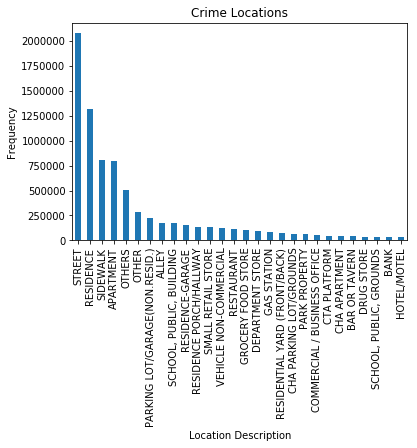

In [114]:
crime_loc2 = crime_loc2.sort_values(by=['ID'], ascending = False)
ax=crime_loc2.plot.bar()
ax.set_ylabel('Frequency')
ax.set_title('Crime Locations')
ax.get_legend().remove()


In [145]:
#Whole list for reference

crime_loc2

,ID
Location Description,
STREET,2079333
RESIDENCE,1313749
SIDEWALK,808798
APARTMENT,801188
OTHERS,510055
OTHER,287270
PARKING LOT/GARAGE(NON.RESID.),222772
ALLEY,178674
"SCHOOL, PUBLIC, BUILDING",172165


In [143]:
#Same process except grouping by Ward

#Removed NaN values from Ward and change floats to ints
crime_coord = crime_coord[crime_coord.Ward.notnull()]
crime_coord['Ward']=crime_coord['Ward'].astype(int)


crime_ward = crime_coord.groupby('Ward').count()
crime_ward = crime_ward.filter(items=['Ward','ID'])
crime_ward = crime_ward.sort_values(by=['ID'], ascending = False)

crime_ward.head()

,ID
Ward,
28,328010
24,271574
2,271003
42,265239
27,255182


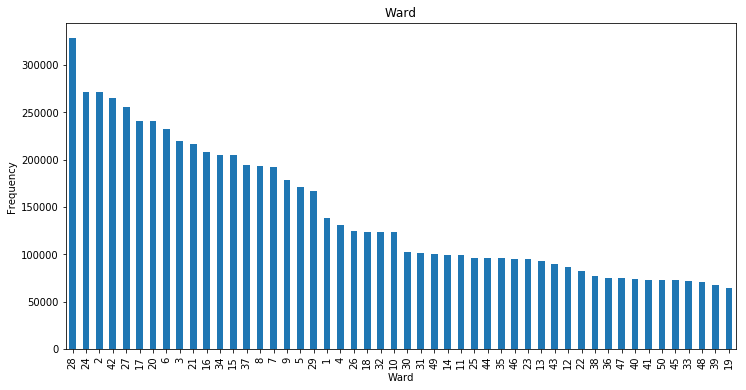

In [144]:

ax=crime_ward.plot.bar(figsize = (12,6))
ax.set_ylabel('Frequency')
ax.set_title('Ward')
ax.get_legend().remove()

In [146]:
#Whole list for reference

crime_ward

,ID
Ward,
28,328010
24,271574
2,271003
42,265239
27,255182
17,241058
20,240534
6,231985
3,219806


Sample data for more manageable dataset and export to excel for heat mapping in Tableau:

In [8]:
crime_sample = crime_coord.sample(100000)

In [9]:
crime_sample.to_excel('crime_sample.xlsx')